# Preliminaries
In this first part we simply import all the libraries necessary to correctly run the whole project, we initialize GeDiM4Py and the geometry parameters for the mesh.

### Import libraries

In [1]:
%pip install pandas

import sys, time
sys.path.append('/content/CppToPython')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import GeDiM4Py as gedim

### Initialize GeDiM4Py

In [3]:
lib = gedim.ImportLibrary("/content/CppToPython/release/GeDiM4Py.so")

config = {'GeometricTolerance': 1.0e-8}

gedim.Initialize(config, lib)

### Set geometry parameters

In [4]:
meshSize = 0.001
order = 1

# Boundary conditions are all Homogenous Dirichlet BCs, we use only one marker (= 1) for the border
domain = {'SquareEdge': 1.0, 'VerticesBoundaryCondition': [1, 1, 1, 1], 'EdgesBoundaryCondition': [1, 1, 1, 1], 'DiscretizationType': 1, 'MeshCellsMaximumArea': meshSize} 
[meshInfo, mesh] = gedim.CreateDomainSquare(domain, lib)
# Order=order -> Order of finite element
# BoundaryConditionsType=2 -> Dirichlet BCs
discreteSpace = {'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 2]} 
[problemData, dofs, strongs] = gedim.Discretize(discreteSpace, lib)

gedim.PlotMesh(mesh)

# Nonlinear Elliptic Problem: POD vs PINNs and POD-nn

Aim of the project is to solve the following parametrized problem on the bidimensional spatial domain
\begin{equation*}
    \bar{\Omega} = [0, 1] \times [0, 1]
\end{equation*}
Given
\begin{equation*}
    \mathbf{\mu}=(\mu_0, \mu_1)\in\mathcal{P}=[0.1,1]\times[0.1,1]
\end{equation*}
find $u(\mathbf{\mu})$ such that
$$
\begin{cases}
\displaystyle - \Delta u(\mathbf{\mu}) + \frac{\mu_0}{\mu_1} \left(e^{\mu_1\,u(\mathbf{\mu})}-1\right) = g(\mathbf{x};\mathbf{\mu}) & \text{in } \Omega\\
u = 0.0 & \text{in } ∂Ω
\end{cases}
$$
Source term is defined as
\begin{equation*}
    g(\mathbf{x};\mathbf{\mu})=100\,sin(2\pi x_0)\,cos(2\pi x_1)\quad \forall\,\mathbf{x}=(x_0, x_1) \in\Omega
\end{equation*} 

## Weak Formulation
The weak formulation of the problem reads: find $u \in V := H^1_0(\Omega)$ such that
\begin{equation*}
    \int_{\Omega} \nabla u\cdot\nabla v + \frac{\mu_0}{\mu_1} \int_{\Omega} \left(e^{\mu_1\,u(\mathbf{\mu})}-1\right) v - \int_{\Omega} g\, v = 0 \quad \forall v \in V
\end{equation*}
We can rearange this formulation as
\begin{equation*}
    f(u; v) := f_1(u; v) + f_2(u; v) + f_3(u; v) = 0 \quad \forall v \in V
\end{equation*}
having
$$
\begin{align*}
    f_1(u; v) &= \int_{\Omega} \nabla u\cdot\nabla v \\
    f_2(u; v) &= \frac{\mu_0}{\mu_1} \int_{\Omega} \left(e^{\mu_1\,u(\mathbf{\mu})}-1\right) v \\
    f_3(u; v) &= - \int_{\Omega} g\, v
\end{align*}
$$

## Newton Schema
Since $f(u; v)$ is non-linear with respect to $\mu$, we are not able to separate variables, however we can implement the Newton schema in order to solve, for each iteration $k$, the following problem
\begin{equation*}
    J_f [\partial u]_{|_{u_k}} \partial u = - f(u_k; v) = 0 \quad \forall v \in V
\end{equation*}
having $J_f [\partial u]_{|_{u_k}}$ to be the evaluation of the Jacobian of $J_f$ in the point $u_k$ along the direction $\partial u$.

Both functions $f_1(u; v)$ and $f_3(u; v)$ are linear in $u$, this implies that their Gateux derivatives are respectively
$$
\begin{align*}
    J_{f_1} [\partial u]_{|_{u_k}} &= f_1(u; v)=\int_{\Omega} \nabla \partial u \cdot \nabla v \\
    \qquad J_{f_3} [\partial u]_{|_{u_k}} &= 0 
\end{align*}
$$
On the other hand $f_3(u; v)$ is non-linear in u, and its Gateaux derivative is given by
\begin{align*}
    J_{f_2} [\partial u]_{|_{u_k}}&=\lim_{h\to0}\frac{f_2(u_k+\partial u\, h)-f(u_k)}{h}=\\
    \\
    &=\frac{\mu_0}{\mu_1}\lim_{h\to0}\frac{1}{h}\int_{\Omega} \left(e^{\mu_1\,(u_k+\partial u\, h)}-1\right) v-\int_{\Omega} \left(e^{\mu_1\,u_k}-1\right) v=\\
    \\
    &=\frac{\mu_0}{\mu_1}\lim_{h\to0}\frac{1}{h}\int_{\Omega} e^{\mu_1\,u_k}\left(e^{\mu_1\,\partial u\, h}-1\right) v=\\
    \\
    &=\mu_0\int_\Omega e^{\mu_1\,u_k}\, \partial u\,v 
\end{align*}
which is a reaction term.

After some computations we are hable to write down the linear system which needs to be solved in each iteration $k$: fixed $u_k$, find $\partial u$ such that
$$
\int_{\Omega} \nabla \partial u \cdot \nabla v + \mu_0\int_\Omega e^{\mu_1\,u_k}\, \partial u\,v  = - \int_{\Omega} \underline{\nabla u_k}_{g_1} \cdot \nabla v - \frac{\mu_0}{\mu_1} \int_{\Omega} \underline{\left(e^{\mu_1\,u_k}-1\right)}_{g_2} v + \int_{\Omega} g\, v 
$$
On the left hand side we have the classical diffusion, reaction and advection terms. On the other hand, on the right hand side we have function $f(u; v)$ evaluated in $u_k$.

# 1 POD & ROM with exact solution
Firstly we solve the Nonlinear Elliptic problem by means of POD-Galerkin method over a Finite Element full order model by choosing the exact solution
\begin{equation*}
   u_{ex}(\mathbf{x}; \mathbf{\mu}) = 16\,x_0\,x_1\,(1-x_0)(1-x_1)
\end{equation*}
and computing the respective right hand
$$
\begin{align*}
   g_{ex}(\mathbf{x};\mathbf{\mu}) &= -\Delta u_{ex}(\mathbf{x};\mathbf{\mu}) + \frac{\mu_0}{\mu_1} \left(e^{\mu_1\,u_{ex}(\mathbf{x};\mathbf{\mu})}-1\right) \\
   &= 32x_0(1-x_0) + 32x_1(1-x_1) + \frac{\mu_0}{\mu_1} \left(e^{\mu_1\,16\,x_0\,x_1\,(1-x_0)(1-x_1)}-1\right)
\end{align*}
$$

### $\mu$ parameters definition

In [ ]:
mu = [0.8, 0.4]

### Matrices construction functions
From now on we indicate as numPoints the quadrature points used to evaluate the basis functions

In [6]:
# Stiffness Matrix
def diffusion(numPoints, points):
	return np.ones(numPoints, order='F').ctypes.data

# Reaction Matrix
def reaction(numPoints, points):
	return (mu[0] * np.ones(numPoints, order='F')).ctypes.data

# Coefficient depending on uK (evaluated in the quadrature points)
def reactionNonLinear(numPoints, points, u, uX, uY):
	vecu = gedim.make_nd_array(u, numPoints, np.double)
	nonlinearValues = np.exp(mu[1] * vecu)
	return nonlinearValues.ctypes.data

# Right hand side gEx computed so that u(x0, x1) = 16*x0*x1*(1-x0)*(1-x1) woul be the exact solution of the nonlinear elliptic problem
def rhsExactG(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	exactGValues = 32.0 * (matPoints[1, :] * (1.0 - matPoints[1, :]) + matPoints[0, :] * (1.0 - matPoints[0, :])) + mu[0] / mu[1] * (np.exp(mu[1] * 16 * matPoints[0, :] * matPoints[1, :] * (1.0 - matPoints[0, :]) * (1.0 - matPoints[1, :])) - 1)
	return exactGValues.ctypes.data

# Right hand side g given from the problem
def rhsG(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	gValues = 100.0 * np.sin(2 * np.pi * matPoints[0, :]) * np.cos(2 * np.pi * matPoints[1, :])
	return gValues.ctypes.data

# Nonlinear term evaluated in uK and quadrature points
def rhsNonlinearG2(numPoints, points, u, uX, uY):
	vecu = gedim.make_nd_array(u, numPoints, np.double)
	valuesNl = mu[0] / mu[1] * (np.exp(mu[1] * vecu) - 1)
	return valuesNl.ctypes.data

# Diffusion term evaluated in uK
def rhsNonlinearG1(numPoints, points, u, uX, uY):
	vecuX = gedim.make_nd_array(uX, numPoints, np.double)
	vecuY = gedim.make_nd_array(uY, numPoints, np.double)
	valuesNlDF = np.zeros((2, numPoints), order='F')
	valuesNlDF[0, :] = vecuX
	valuesNlDF[1, :] = vecuY
	return valuesNlDF.ctypes.data

# Evaluation of the exact solution in every quadrature point
def exactSolution(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	exactValues = 16.0 * (matPoints[1,:] * (1.0 - matPoints[1, :]) * matPoints[0, :] * (1.0 - matPoints[0, :]))
	return exactValues.ctypes.data

# Derivatives in each direction
def exactDerivativeSolution(direction, numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	if direction == 0:
		valuesExD = 16.0 * (1.0 - 2.0 * matPoints[0, :]) * matPoints[1, :] * (1.0 - matPoints[1, :])
	elif direction == 1:
		valuesExD = 16.0 * (1.0 - 2.0 * matPoints[1, :]) * matPoints[0, :] * (1.0 - matPoints[0, :])
	else:
		valuesExD = np.zeros(numPoints, order='F')
	return valuesExD.ctypes.data

def ones(numPoints, points):
	return np.ones(numPoints, order='F').ctypes.data

def onesDerivative(numPoints, points):
	return np.ones((2, numPoints), order='F').ctypes.data

def zeros(numPoints, points):
	return np.zeros(numPoints, order='F').ctypes.data

# The gradient is null in every direction
def zerosDerivative(direction, numPoints, points):
	return np.zeros(numPoints, order='F').ctypes.data

### High fidelity solution

In [8]:
def fom(mu, lib, problemData, exactSol=False):
    residualNorm = 1.0
    solutionNorm = 1.0
    newtonTol = 1.0e-5
    maxIters = 25
    countIters = 1
    
    # Initial solution
    uK = np.zeros(problemData['NumberDOFs'], order='F') 
    uStrong = np.zeros(problemData['NumberStrongs'], order='F')

    stiffness = gedim.AssembleStiffnessMatrix(diffusion, problemData, lib)[0]

    if exactSol:
        forcingTermGEx = gedim.AssembleForcingTerm(rhsExactG, problemData, lib)
    else:
        forcingTermG = gedim.AssembleForcingTerm(rhsG, problemData, lib)
    
    while countIters < maxIters and residualNorm > newtonTol * solutionNorm: 
        reactionTerm = gedim.AssembleNonLinearReactionMatrix(reaction, reactionNonLinear, uK, uStrong, problemData, lib)[0]

        # Diffusion and Nonlinear term evaluated in uK
        forcingTermDerV = gedim.AssembleNonLinearDerivativeForcingTerm(onesDerivative, rhsNonlinearG1, uK, uStrong, problemData, lib)
        forcingTermV = gedim.AssembleNonLinearForcingTerm(ones, rhsNonlinearG2, uK, uStrong, problemData, lib)
            
        # Compute Full Order Model solution
        if exactSol: 
            dU = gedim.LUSolver(stiffness + reactionTerm, forcingTermGEx - forcingTermV - forcingTermDerV, lib)
        else:
            dU = gedim.LUSolver(stiffness + reactionTerm, forcingTermG - forcingTermV - forcingTermDerV, lib)
    
        # Newton step
        uK = uK + dU

        # Error
        dUNormL2 = gedim.ComputeErrorL2(zeros, dU, np.zeros(problemData['NumberStrongs'], order='F'), lib) 
        uNormL2 = gedim.ComputeErrorL2(zeros, uK, uStrong, lib) # Aim it is zero
        uNormH1 = gedim.ComputeErrorH1(zerosDerivative, uK, uStrong, lib) # Again we aim it is zero

        if exactSol:
            uErrorL2 = gedim.ComputeErrorL2(exactSolution, uK, uStrong, lib)
            uErrorH1 = gedim.ComputeErrorH1(exactDerivativeSolution, uK, uStrong, lib)
        
        solutionNorm = uNormL2
        residualNorm = dUNormL2

        if exactSol:
            print("\ndofs", "h", "errorL2", "errorH1", "residual", "iteration", "max_iteration")
            print(problemData['NumberDOFs'], '{:.16e}'.format(problemData['H']), '{:.16e}'.format(uErrorL2 / uNormL2), '{:.16e}'.format(uErrorH1 / uNormH1), '{:.16e}'.format(residualNorm / uNormL2), '{:d}'.format(countIters), '{:d}'.format(maxIters)) 
        else:
            print("\ndofs", "h", "residual", "iteration", "max_iteration")
            print(problemData['NumberDOFs'], '{:.16e}'.format(problemData['H']), '{:.16e}'.format(residualNorm / uNormL2), '{:d}'.format(countIters), '{:d}'.format(maxIters)) 
        
        countIters = countIters + 1
    
    if exactSol:
        return uK, uStrong, (uErrorL2 / uNormL2), (uErrorH1 / uNormH1), residualNorm # Slops for the two orders of convergence (m0 = 1 e m1 = 0,5)
    else:
        return uK, uStrong, uNormL2, uNormH1, residualNorm
    

### FOM order of convergence as a function of MeshSizes

In [ ]:
meshSizes = [0.1, 0.01, 0.001, 0.0001]
errorL2 = []
errorH1 = []

for size in meshSizes:
    # Build Mesh
    gedim.CreateDomainSquare({'SquareEdge': 1.0, 'VerticesBoundaryCondition': [1,1,1,1], 'EdgesBoundaryCondition': [1,1,1,1], 'DiscretizationType': 1, 'MeshCellsMaximumArea': size}, lib)
    problemData = gedim.Discretize({'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 2]} , lib)[0] # [0] to keep only the first output of Discretize function
    # FOM Solution
    [_, _, errorRelL2, errorRelH1, _] = fom(mu, lib, problemData, exactSol=True)
    errorL2.append(errorRelL2)
    errorH1.append(errorRelH1)

plt.clf()
x = meshSizes
y = errorL2
fig, ax = plt.subplots()
ax.plot(x, y, label='Error in L2 norm')
y = errorH1
ax.plot(x, y, label='Error in H1 norm')
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
plt.title("FOM error w.r.t. the exact solution in L2 and H1 norm")
plt.xlabel("Meshsize")
plt.ylabel("Errors")
plt.savefig("Errors_FOM.png")

# Order of convergence in L2 and H1 norm
pcoeffL2 = np.polyfit(np.log(x), np.log(errorL2), 1)
pcoeffH1 = np.polyfit(np.log(x), np.log(errorH1), 1)
orderL2 = pcoeffL2[0]
orderH1 = pcoeffH1[0]
print("L2 Order:", orderL2, "- H1 Order:", orderH1)
pd.DataFrame({'OrderL2': [orderL2], 'OrderH1': [orderH1]}).to_csv("orders.csv")

# Since the POD algorithm converges, we can apply it in order to solve the problem with unknown solution

## 1.1 POD

### Parameters sampling
We start by defining the training set for the POD method obtained by uniformly sampling from the prameters' space $\mathcal{P}=[0.1,1]^2$

In [8]:
snapshotsCount = 100
mu0Range = [0.1, 1.]
mu1Range = [0.1, 1.]

np.random.seed(1)

P = np.array([mu0Range, mu1Range])

trainingSet = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(snapshotsCount, P.shape[0]))

### Snapshot matrix

We can now build the Snapshot matrix. The problem is not affine in the parameters so we need to assemble the Reaction matrix and the Nonlinear Forcing Term for each parametric instance

In [9]:
# Build Working Mesh
gedim.CreateDomainSquare({'SquareEdge': 1.0, 'VerticesBoundaryCondition': [1,1,1,1], 'EdgesBoundaryCondition': [1,1,1,1], 'DiscretizationType': 1, 'MeshCellsMaximumArea': meshSize}, lib)
problemData = gedim.Discretize({'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 2]} , lib)[0]

def buildSnapshotMatrix(problemData, trainingSet, exSolution=True):
    snapshotMatrix = []
    for mu in trainingSet:
        uK = fom(mu, lib, problemData, exactSol=exSolution)[0] # We keep only the first output uK
        snapshotMatrix.append(np.copy(uK))
    snapshotMatrix = np.array(snapshotMatrix)
    print(f'Snapshot Matrix dimension: {snapshotMatrix.shape}')
    return snapshotMatrix

snapshotMatrix = buildSnapshotMatrix(problemData, trainingSet)

### Covariance matrix 
We now build the Covariance Matrix. Inner product is mandatory since we are dealing with the Energy Norm and not the L2 one. This implies that the obtained basis won't be the best possible but an approximation

In [10]:
tol = 1. - 1e-7
NMax = 10

def covarianceMatrix(snapshotMatrix):
    stiffnessMatrix = gedim.AssembleStiffnessMatrix(diffusion, problemData, lib)[0]
    innerProduct = stiffnessMatrix
    
    C = snapshotMatrix @ innerProduct @ np.transpose(snapshotMatrix)
    
    # Compute eigenvalues and eigenvectors
    Le, VMe = np.linalg.eig(C)
    eigenvalues = []
    eigenvectors = []
    for i in range(len(Le)):
        eigReal = Le[i].real
        eigComplex = Le[i].imag
        assert np.isclose(eigComplex, 0.)
        eigenvalues.append(eigReal)
        eigenvectors.append(VMe[i].real)  
    totalEnergy = sum(eigenvalues)
    retainedEnergyVector = np.cumsum(eigenvalues)
    relativeRetainedEnergy = retainedEnergyVector / totalEnergy
    if all(flag == False for flag in relativeRetainedEnergy >= tol):
        N = NMax
    else:
        N = np.argmax(relativeRetainedEnergy >= tol) + 1
    print("The reduced dimension is ", N)
    print(relativeRetainedEnergy)
    return N, innerProduct, eigenvectors

[N, innerProduct, eigenvectors] = covarianceMatrix(snapshotMatrix)

### Basis matrix
We are now able to build the basis functions and $\mathbb B$.

In [11]:
def buildBasisFunctions(N, snapshotMatrix, innerProduct, eigenvectors):
    basisFunctions = []
    for n in range(N):
        eigenvector = eigenvectors[n]
        basis = np.transpose(snapshotMatrix) @ eigenvector
        norm = np.sqrt(np.transpose(basis) @ innerProduct @ basis)
        basis = basis / norm
        basisFunctions.append(np.copy(basis))
    basisFunctions = np.transpose(np.array(basisFunctions))
    print(f'Basis functions dimension: {basisFunctions.shape}')
    return basisFunctions

basisFunctions = buildBasisFunctions(N, snapshotMatrix, innerProduct, eigenvectors)

## 1.2 ROM

### Implement Newton algorithm and assemble the system

In [12]:
def rom(mu, lib, problemData, exactSol=True):
    residualNormPrj = 1.0
    solutionNormPrj = 1.0
    newtonTol = 1.0e-5
    maxIters = 25
    countIters = 1
    
    # Initial solution
    uKPrj = np.zeros(problemData['NumberDOFs'], order='F') 
    uStrong = np.zeros(problemData['NumberStrongs'], order='F')
    reducedUk = np.zeros(N, order='F')

    stiffness = gedim.AssembleStiffnessMatrix(diffusion, problemData, lib)[0]

    # Forcing term given by the problem
    if exactSol:
        forcingTermExactG = gedim.AssembleForcingTerm(rhsExactG, problemData, lib)
    else:
        forcingTermG = gedim.AssembleForcingTerm(rhsG, problemData, lib)  
    
    while countIters < maxIters and residualNormPrj > newtonTol * solutionNormPrj:
        reactionTerm = gedim.AssembleNonLinearReactionMatrix(reaction, reactionNonLinear, uKPrj, uStrong, problemData, lib)[0]
        reactionTerm = mu[0] * reactionTerm

        # Diffusion and Nonlinear terms evaluated in uK
        forcingTermDerV = gedim.AssembleNonLinearDerivativeForcingTerm(onesDerivative, rhsNonlinearG1, uKPrj, uStrong, problemData, lib)
        forcingTermV = gedim.AssembleNonLinearForcingTerm(ones, rhsNonlinearG2, uKPrj, uStrong, problemData, lib)
        reducedStiffness = np.transpose(basisFunctions) @ stiffness @ basisFunctions
        reducedReaction = np.transpose(basisFunctions) @ reactionTerm @ basisFunctions

        if exactSol:
            reducedForcingTermExactG =  np.transpose(basisFunctions) @ forcingTermExactG
        else:
            reducedForcingTermG =  np.transpose(basisFunctions) @ forcingTermG
            
        reducedForcingTermDerV =  np.transpose(basisFunctions) @ forcingTermDerV
        reducedForcingTermV =  np.transpose(basisFunctions) @ forcingTermV

        # Reduced solution
        if exactSol:
            reducedDu = gedim.LUSolver(reducedStiffness + reducedReaction, reducedForcingTermExactG - reducedForcingTermDerV - reducedForcingTermV, lib)
        else:
            reducedDu = gedim.LUSolver(reducedStiffness + reducedReaction, reducedForcingTermG - reducedForcingTermDerV - reducedForcingTermV, lib)
        
        # Newton step
        reducedUk = reducedUk + reducedDu
        
        # Projection of reduced soution uK
        uKPrj = basisFunctions @ reducedUk 
        duPrj = basisFunctions @ reducedDu

        # Errors
        dUNormL2 = gedim.ComputeErrorL2(zeros, duPrj, np.zeros(problemData['NumberStrongs'], order='F'), lib) 
        uNormL2 = gedim.ComputeErrorL2(zeros, uKPrj, uStrong, lib)
        uNormH1 = gedim.ComputeErrorH1(zerosDerivative, uKPrj, uStrong, lib)

        if exactSol:
            uErrorL2 = gedim.ComputeErrorL2(exactSolution, uKPrj, uStrong, lib)
            uErrorH1 = gedim.ComputeErrorH1(exactDerivativeSolution, uKPrj, uStrong, lib)
        
        solutionNormPrj = uNormL2
        residualNormPrj = dUNormL2

        if exactSol:
            print("dofs", "h", "errorL2", "errorH1", "residual", "iteration", "max_iteration")
            print(problemData['NumberDOFs'], '{:.16e}'.format(problemData['H']), '{:.16e}'.format(uErrorL2 / uNormL2), '{:.16e}'.format(uErrorH1 / uNormH1), '{:.16e}'.format(residualNormPrj / uNormL2), '{:d}'.format(countIters), '{:d}'.format(maxIters))
        else:
            print("dofs", "h", "residual", "iteration", "max_iteration")
            print(problemData['NumberDOFs'], '{:.16e}'.format(problemData['H']), '{:.16e}'.format(residualNormPrj / uNormL2), '{:d}'.format(countIters), '{:d}'.format(maxIters))

        countIters = countIters + 1
    return uKPrj, uStrong

### Errors and Order of Convergence as a function of MeshSizes

In [ ]:
def exctSolution(quadPts):
    return 16.0 * (quadPts[1] * (1.0 - quadPts[1]) * quadPts[0] * (1.0 - quadPts[0]))

def exctDerSolution(quadPts):
    return [16.0 * (1.0 - 2.0 * quadPts[0]) * quadPts[1] * (1.0 - quadPts[1]), 16.0 * (1.0 - 2.0 * quadPts[1]) * quadPts[0] * (1.0 - quadPts[0])]

def errorExactVsRom(predPointsRom, uStrong):
    [numQuadPts, quadPts, quadWgts, sol, solX, solY] = gedim.EvaluateSolutionOnPoints(predPointsRom, uStrong, lib)
    errorL2 = np.float64(0)
    errorH1 = np.float64(0)
    normL2Exact = 0
    normH1Exact = 0

    for q in range(numQuadPts):
        excSol = exctSolution(quadPts[:, q])
        excSolDev = exctDerSolution(quadPts[:, q])
        
        errorL2 = errorL2 + quadWgts[q] * np.square(excSol - sol[q])
        errorH1 = errorH1 + quadWgts[q] * (np.square(excSolDev[0] - solX[q]) + np.square(excSolDev[1] - solY[q]))
        
        normL2Exact = normL2Exact + quadWgts[q] * (np.square(excSol))
        normH1Exact = normH1Exact + quadWgts[q] * (np.square(excSolDev[0]) + np.square(excSolDev[1]))
    
    return np.sqrt(errorL2), np.sqrt(errorH1), np.sqrt(normL2Exact), np.sqrt(normH1Exact)

######################################################################################################################

snapshotsCount = 50
mu = [0.8, 0.4]
mu0Range = [0.1, 1.]
mu1Range = [0.1, 1.]
np.random.seed(1)

P = np.array([mu0Range, mu1Range])

trainingSet = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(snapshotsCount, P.shape[0]))

meshSizes = [0.1, 0.01, 0.001]
errorL2Abs = []
errorH1Abs = []
errorL2Rel = []
errorH1Rel = []

for size in meshSizes:
    # Build Mesh
    gedim.CreateDomainSquare({'SquareEdge': 1.0, 'VerticesBoundaryCondition': [1, 1, 1, 1], 'EdgesBoundaryCondition': [1, 1, 1, 1], 'DiscretizationType': 1, 'MeshCellsMaximumArea': size}, lib)
    problemData = gedim.Discretize({'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 2]} , lib)[0]
    
    # Build Snapshot Matrix
    snapshotMatrix = buildSnapshotMatrix(problemData, trainingSet)

    # Build Covariance Matrix
    [N, innerProduct, eigenvectors] = covarianceMatrix(snapshotMatrix)

    # Compute Basis Functions
    basisFunctions = buildBasisFunctions(N, snapshotMatrix, innerProduct, eigenvectors)
    
    # ROM 
    [predPointsRom, uStrong] = rom(mu, lib, problemData, exactSol=True)
    
    # Errors
    [errorL2Rom, errorH1Rom, normL2Exact, normH1Exact] = errorExactVsRom(predPointsRom, uStrong)
    errorL2Abs.append(errorL2Rom)
    errorH1Abs.append(errorH1Rom)
    errorL2Rel.append(errorL2Rom / normL2Exact)
    errorH1Rel.append(errorH1Rom / normH1Exact)

######################################################################################################################

plt.clf()
x = meshSizes
y = errorL2Rel
fig, ax = plt.subplots()
ax.plot(x, y, label='L2norm Error')
y = errorH1Rel
ax.plot(x, y, label='H1norm Error')
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
plt.title("ROM errors with POD w.r.t. the exact solution in L2 and H1 norm")
plt.xlabel("Meshsize")
plt.ylabel("Errors")
plt.savefig("Errors_L2_H1_ROM.png")

pcoeffL2 = np.polyfit(np.log(x), np.log(errorL2Rel), 1)
pcoeffH1 = np.polyfit(np.log(x), np.log(errorH1Rel), 1)
orderL2 = pcoeffL2[0]
orderH1 = pcoeffH1[0]
print("L2 Order: ", orderL2, "H1 order: ", orderH1)
pd.DataFrame({'OrderL2': [orderL2], 'OrderH1': [orderH1]}).to_csv("orders_ROMvsEXACT.csv")

### ROM VS FOM: Absolute and Relative Errors and SpeedUp

In [ ]:
absError = []
relError = []
testingSet = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(50, P.shape[0]))
uKs = []
uKPrjs = []

fomTime = time.time()
for mu in testingSet:
    uKs.append(fom(mu, lib, problemData, exactSol=True)[0]) # [0] means we only keep uK
fomTime = time.time() - fomTime

romTime = time.time()
for mu in testingSet:
    uKPrjs.append(rom(mu, lib, problemData, exactSol=True)[0]) # [0] means we only keep uKPrj
romTime = time.time() - romTime

speedUp = fomTime / romTime

for i in range(len(uKs)):
    error = uKs[i] - uKPrjs[i]
    errorNormSquared = np.transpose(error) @ innerProduct @ error
    absoluteError = np.sqrt(np.abs(errorNormSquared))
    absError.append(absoluteError)

    fomNormSquared = np.transpose(uKs[i]) @  innerProduct @ uKs[i]
    relError.append(absoluteError / np.sqrt(abs(fomNormSquared)))

print(f'Average relative error: {np.mean(relError)}')
print(f'Average absolute error: {np.mean(absError)}')
print(f'SpeedUp : {speedUp}')

### Plot ROM solution

In [ ]:
[uK, uStrong] = rom(mu, lib, problemData, exactSol=True)

gedim.PlotSolution(mesh, dofs, strongs, uK, uStrong)

# 2 POD without exact solution
We now numerically find the unknown solution of the nonlinear elliptic problem with the forcing term given by 
$$
g(\mathbf{x};\mathbf{\mu})=100\,sin(2\pi x_0)\,cos(2\pi x_1)\quad \forall\,\mathbf{x}=(x_0, x_1) \in\Omega
$$

### Snapshot matrix 

In [14]:
snapshotsCount = 100
mu0Range = [0.1, 1.]
mu1Range = [0.1, 1.]

np.random.seed(1)

P = np.array([mu0Range, mu1Range])
trainingSet = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(snapshotsCount, P.shape[0]))

# Build Working Mesh
gedim.CreateDomainSquare({'SquareEdge': 1.0, 'VerticesBoundaryCondition': [1, 1, 1, 1], 'EdgesBoundaryCondition': [1, 1, 1, 1], 'DiscretizationType': 1, 'MeshCellsMaximumArea': meshSize}, lib)
problemData = gedim.Discretize({'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 2]}, lib)[0]

snapshotMatrix = buildSnapshotMatrix(problemData, trainingSet, exSolution=False)

### Covariance matrix

In [ ]:
[N, innerProduct, eigenvectors] = covarianceMatrix(snapshotMatrix)

### Basis matrix

In [ ]:
basisFunctions = buildBasisFunctions(N, snapshotMatrix, innerProduct, eigenvectors)

### ROM: Errors and SpeedUp

In [ ]:
absError = []
relError = []
testingSet = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(50, P.shape[0]))
uKs = []
uKPrjs = []

fomTime = time.time()
for mu in testingSet:
    uKs.append(fom(mu, lib, problemData, exactSol=False)[0]) # [0] means we only keep uK
fomTime = time.time() - fomTime

romTime = time.time()
for mu in testingSet:
    uKPrjs.append(rom(mu, lib, problemData, exactSol=False)[0]) # [0] means we only keep uKPrj
romTime = time.time() - romTime

speedUp = fomTime / romTime

for i in range(len(uKs)):
    error = uKs[i] - uKPrjs[i]
    errorNormSquared = np.transpose(error) @ innerProduct @ error
    absoluteError = np.sqrt(np.abs(errorNormSquared))
    absError.append(absoluteError)

    fomNormSquared = np.transpose(uKs[i]) @  innerProduct @ uKs[i]
    relError.append(absoluteError / np.sqrt(abs(fomNormSquared)))

print(f'Average relative error: {np.mean(relError)}')
print(f'Average absolute error: {np.mean(absError)}')
print(f'SpeedUp : {speedUp}')

pd.DataFrame({'Error_rel_H1_FOM_ROM': [np.mean(relError)], 'Error_abs_H1_FOM_ROM': [np.mean(absError)], 'Speed_up_POD': [speedUp]}).to_csv("speed_up_POD_problem.csv")

### Errors on quadrature points

In [139]:
def errorFomVsRom(pointsRom, pointsFom, uStrong):
    [numQuadraturePoints, _, quadratureWeights, solRom, solXRom, solYRom] = gedim.EvaluateSolutionOnPoints(pointsRom, uStrong, lib)
    [_, _, _, solFom, solXFom, solYFom] = gedim.EvaluateSolutionOnPoints(pointsFom, uStrong, lib)
    
    errorL2Rom = np.float64(0)
    errorH1Rom = np.float64(0)
    normL2Fom = 0
    normH1Fom = 0
    
    for q in range(numQuadraturePoints):
        errorL2Rom = errorL2Rom + quadratureWeights[q] * np.square(solFom[q] - solRom[q])
        errorH1Rom = errorH1Rom + quadratureWeights[q] * (np.square(solXFom[q] - solXRom[q]) + np.square(solYFom[q] - solYRom[q]))
        
        normL2Fom = normL2Fom + quadratureWeights[q] * (np.square(solFom[q]))
        normH1Fom = normH1Fom + quadratureWeights[q] * (np.square(solXFom[q]) + np.square(solYFom[q]))
    
    return np.sqrt(errorL2Rom), np.sqrt(errorH1Rom), np.sqrt(normL2Fom), np.sqrt(normH1Fom)

###################################################################################################################################################

absErrorL2 = []
relErrorL2 = []
absErrorH1 = []
relErrorH1 = []
testingSet = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(50, P.shape[0]))
uKs = []
uKPrjs = []

fomTime = time.time()
for mu in testingSet:
    uKs.append(fom(mu, lib, problemData, exactSol=False)[0]) # [0] means we only keep uK
fomTime = time.time() - fomTime

romTime = time.time()
for mu in testingSet:
    uKPrjs.append(rom(mu, lib, problemData, exactSol=False)[0]) # [0] means we only keep uKPrj
romTime = time.time() - romTime

speedUp = fomTime / romTime

for i in range(len(uKs)):
    [errorL2ROMvsFOM, errorH1ROMvsFOM, normL2Fom, normH1Fom] = errorFomVsRom(uKPrjs[i], uKs[i], np.zeros(problemData['NumberStrongs'], order='F'))
    absErrorL2.append(errorL2ROMvsFOM)
    absErrorH1.append(errorH1ROMvsFOM)
    relErrorL2.append(errorL2ROMvsFOM / normL2Fom)
    relErrorH1.append(errorH1ROMvsFOM / normH1Fom)
# CHECK
print(f'H1 Error ROM wrt FOM: {np.mean(relErrorH1)}')
print(f'L2 Error ROM wrt FOM: {np.mean(relErrorL2)}')

pd.DataFrame({'Error_rel_L2_FOM_ROM': [np.mean(relErrorL2)],'Error_abs_L2_FOM_ROM': [np.mean(absErrorL2)],'Error_rel_H1_FOM_ROM': [np.mean(relErrorH1)], 'Error_abs_H1_FOM_ROM': [np.mean(absErrorH1)], 'Speed_up_POD': [speedUp]}).to_csv("speed_up_POD_quadform.csv")

### Plot Solution

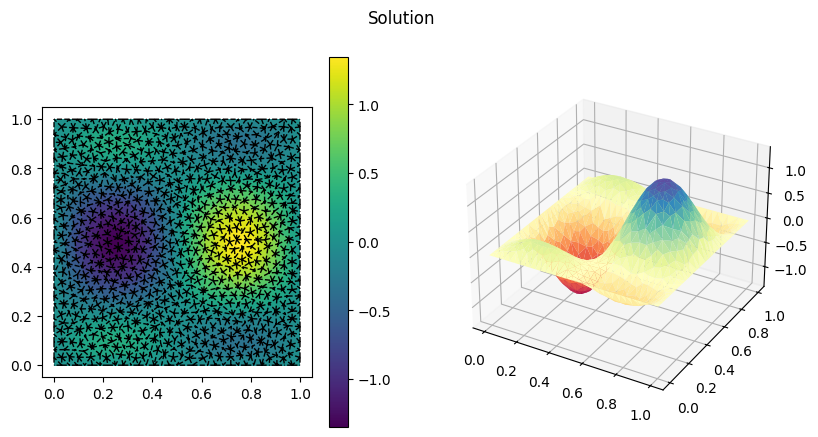

In [67]:
[uKPrj, uStrong] = rom(mu, lib, problemData, exactSol=False)

gedim.PlotSolution(mesh, dofs, strongs, uKPrj, uStrong)

gedim.ExportSolution(exactSolution, uKPrj, uStrong, lib)

# 3 Parametric PINN

## Network

In [22]:
# Set seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.input_layer = nn.Linear(4, 7) # 4 inputs = x0, x1, mu0, mu1

        self.hidden_layer1 = nn.Linear(7, 7) # n[input] + m[output] + 2 = 7 neurons per layer [from UAT-2]
        self.hidden_layer2 = nn.Linear(7, 7)
        self.hidden_layer3 = nn.Linear(7, 7)
        self.hidden_layer4 = nn.Linear(7, 7)
        
        self.output_layer = nn.Linear(7, 1) # 1 output = u [scalar]

    def forward(self, x0, x1, mu0, mu1): # we put sigmoid over all the layers
        input = torch.cat([x0, x1, mu0, mu1], axis=1) # combines the column array
        
        layer1output = torch.Softplus(self.input_layer(input))
        layer2output = torch.Softplus(self.hidden_layer1(layer1output))
        layer3output = torch.Softplus(self.hidden_layer2(layer2output))
        layer4output = torch.Softplus(self.hidden_layer3(layer3output))
        layer5output = torch.Softplus(self.hidden_layer4(layer4output))
        
        output = self.output_layer(layer5output)
        return output

### Residual function (PDE as the Loss function)

In [25]:
def R(x0, x1, mu0, mu1, net, exactSol=False):
    u = net(x0, x1, mu0 , mu1) # prediction
    u_x0 = torch.autograd.grad(u.sum(), x0, create_graph=True)[0] # derivative of u over x0
    u_xx0 = torch.autograd.grad(u_x0.sum(), x0, create_graph=True)[0] # second derivative of u over x0
    u_x1 = torch.autograd.grad(u.sum(), x1, create_graph=True)[0] # derivative of u over x1
    u_xx1 = torch.autograd.grad(u_x1.sum(), x1, create_graph=True)[0] # second derivative of u over x1
    u_xx = u_xx0 + u_xx1

    if exactSol:
        g = torch.Tensor(32.0 * (x1.detach().numpy() * (1.0 - x1.detach().numpy()) + x0.detach().numpy() * (1.0 - x0.detach().numpy())) + \
                      	 +  mu0.detach().numpy() / mu1.detach().numpy() * (np.exp(mu1.detach().numpy() * 16 * x0.detach().numpy() * x1.detach().numpy() * \
                         (1.0 - x0.detach().numpy()) * (1.0 - x1.detach().numpy())) - 1))
    else:
        g = torch.Tensor(100.0 * np.sin(2 * np.pi * x0.detach().numpy()) * np.cos(2 * np.pi * x1.detach().numpy()))
    
    fNoLin = mu0 / mu1 * (torch.exp(mu1 * u) - 1)
    pde = - u_xx + fNoLin - g
    return pde

### Training set

In [26]:
size = 1000

# Border's training set
x0Bc = np.random.uniform(low=0.0, high=1.0, size=(size, 1))
x1Bc = np.random.uniform(low=0.0, high=1.0, size=(size, 1))
allZeros = np.zeros((size, 1))
allOnes = np.ones((size, 1))
lx0 = np.concatenate([x0Bc, allOnes, x0Bc, allZeros], axis=0)
lx1 = np.concatenate([allZeros, x1Bc, allOnes, x1Bc], axis=0)

# Boundary conditions for u
uBc = np.zeros((size * 4, 1))

# Parameters' training set
trainingSetMu0 = np.random.uniform(low=0.1, high=1.0, size=(size * 4, 1))
trainingSetMu1 = np.random.uniform(low=0.1, high=1.0, size=(size * 4, 1))

# Interior points' training set
x0Int = np.random.uniform(low=0.0, high=1.0, size=(size * 4, 1))
x1Int = np.random.uniform(low=0.0, high=1.0, size=(size * 4, 1))

## 3.1 PINN with exact solution
As done for the POD, firstly we solve the problem by means of PINN method choosing the exact solution
\begin{equation*}
    u_{ex}(\mathbf{x}; \mathbf{\mu}) = 16\,x_0\,x_1\,(1 - x_0)(1 - x_1)
\end{equation*}
using which we get the corresponding right hand side
$$
\begin{align*}
    g_{ex}(\mathbf{x};\mathbf{\mu}) &= -\Delta u_{ex}(\mathbf{x};\mathbf{\mu})+ \frac{\mu_0}{\mu_1} \left(e^{\mu_1\,u_{ex}(\mathbf{x};\mathbf{\mu})} - 1\right) \\
    &= 32x_0(1 - x_0) + 32x_1(1 - x_1)+ \frac{\mu_0}{\mu_1} \left(e^{\mu_1\,16\,x_0\,x_1\,(1-x_0)(1-x_1)}-1\right)
\end{align*}
$$

### Offline phase - Training

In [75]:
def training(iterations, net, mse, coefficient, optimizer, lx0, lx1, trainingSetMu0, trainingSetMu1, x0Int, x1Int, uBc):
    trainingLosses = []
    for epoch in range(iterations):
        optimizer.zero_grad()
    
        # Loss on boundary conditions
        ptX0Bc = Variable(torch.from_numpy(lx0).float(), requires_grad=False)
        ptX1Bc = Variable(torch.from_numpy(lx1).float(), requires_grad=False)
        mu0Tensor = Variable(torch.from_numpy(trainingSetMu0).float(), requires_grad=False)
        mu1Tensor = Variable(torch.from_numpy(trainingSetMu1).float(), requires_grad=False)
        # Homogeneous Dirichlet BC
        ptUbc = Variable(torch.from_numpy(uBc).float(), requires_grad=False)
        # Net output
        netBcOutput = net(ptX0Bc, ptX1Bc, mu0Tensor, mu1Tensor)
        # MSE over u(x)
        mseU = mse(netBcOutput, ptUbc)
        # Loss based on PDE
        allZeros = np.zeros((size * 4, 1))
        
        # Loss on interior points
        ptX0Collocation = Variable(torch.from_numpy(x0Int).float(), requires_grad=True)
        ptX1Collocation = Variable(torch.from_numpy(x1Int).float(), requires_grad=True)
        ptAllZeros = Variable(torch.from_numpy(allZeros).float(), requires_grad=False)
        # Residuals
        residuals = R(ptX0Collocation, ptX1Collocation, mu0Tensor, mu1Tensor, net, True)
        # MSE over residuals
        mseF = mse(residuals, ptAllZeros)
        
        # Combining the loss functions
        loss = mseF + coefficient * mseU
        loss.backward() 
        optimizer.step()

        with torch.autograd.no_grad():
            if epoch % 100 == 0:
                print(epoch,"Loss:",loss.item())
            if epoch % 10 == 0:
                trainingLosses.append(loss.item())
    return net, trainingLosses

In [ ]:
coefficient = 1000
learningRate = 0.01
iterations = 10000

net = Net()
mse = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learningRate)

[net, trainingLoss] = training(iterations, net, mse, coefficient, optimizer, lx0, lx1, trainingSetMu0, trainingSetMu1, x0Int, x1Int, uBc)

PATH = "modelExactSolution.pth"
torch.save(net.state_dict(), PATH)

plt.clf()
plt.plot(range(iterations), trainingLoss) 

### Online phase - Predict

In [103]:
# Build working mesh
meshSize = 0.001
order = 1
domain = {'SquareEdge': 1.0, 'VerticesBoundaryCondition': [1, 1, 1, 1], 'EdgesBoundaryCondition': [1, 1, 1, 1], 'DiscretizationType': 1, 'MeshCellsMaximumArea': meshSize} 
[meshInfo, mesh] = gedim.CreateDomainSquare(domain, lib)
discreteSpace = {'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 2]} 
[problemData, dofs, strongs] = gedim.Discretize(discreteSpace, lib)

# Build needed tensors
x0Bc = strongs[0].reshape(-1, 1)
x1Bc = strongs[1].reshape(-1, 1)
x0BcTensor = Variable(torch.from_numpy(x0Bc).float(), requires_grad=False) # To tensor
x1BcTensor = Variable(torch.from_numpy(x1Bc).float(), requires_grad=False)

x0 = dofs[0].reshape(-1, 1)
x1 = dofs[1].reshape(-1, 1)
x0Tensor = Variable(torch.from_numpy(x0).float(), requires_grad=True) # To tensor
x1Tensor = Variable(torch.from_numpy(x1).float(), requires_grad=True)

mu = [0.8, 0.4]
mu0Tensor = torch.tensor(mu[0], dtype=torch.float32).expand(x0Tensor.size(0), 1)
mu1Tensor = torch.tensor(mu[1], dtype=torch.float32).expand(x1Tensor.size(0), 1)
mu0BcTensor = torch.tensor(mu[0], dtype=torch.float32).expand(x0BcTensor.size(0), 1)
mu1BcTensor = torch.tensor(mu[1], dtype=torch.float32).expand(x1BcTensor.size(0), 1)

In [28]:
def predict(x0Tensor, x1Tensor, mu0Tensor, mu1Tensor, net, exact=False): 
    allZeros = np.zeros((x1Tensor.shape[0], 1))
    ptAllZeros = Variable(torch.from_numpy(allZeros).float(), requires_grad=False) # We want zero residual
    uPredicted = net(x0Tensor, x1Tensor, mu0Tensor, mu1Tensor)
    
    u_x0 = torch.autograd.grad(uPredicted.sum(), x0Tensor, create_graph=True)[0]
    u_xx0 = torch.autograd.grad(u_x0.sum(), x0Tensor, create_graph=True)[0]
    u_x1 = torch.autograd.grad(uPredicted.sum(), x1Tensor, create_graph=True)[0]
    u_xx1 = torch.autograd.grad(u_x1.sum(), x1Tensor, create_graph=True)[0]
    u_xx = u_xx0 + u_xx1

    if exact:
        g = torch.Tensor(32.0 * (x1Tensor.detach().numpy() * (1.0 - x1Tensor.detach().numpy()) + x0Tensor.detach().numpy() * (1.0 - x0Tensor.detach().numpy())) + \
                             +  mu0Tensor.detach().numpy() / mu1Tensor.detach().numpy() * (np.exp(mu1Tensor.detach().numpy() * 16 * x0Tensor.detach().numpy() * x1Tensor.detach().numpy() * \
                            (1.0 - x0Tensor.detach().numpy()) * (1.0 - x1Tensor.detach().numpy())) - 1))
    else:
        g = torch.Tensor(100.0 * np.sin(2 * np.pi * x0Tensor.detach().numpy()) * np.cos(2 * np.pi * x1Tensor.detach().numpy()))
    
    fNonLinear = mu0Tensor / mu1Tensor * (torch.exp(mu1Tensor * uPredicted) - 1)
    pde = - u_xx + fNonLinear - g
    mseF = mse(pde, ptAllZeros)
    
    return uPredicted, mseF

In [ ]:
# Evaluate pretrained model
PATH = "modelExactSolution.pth"
net = Net()
mse = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learningRate)
net.load_state_dict(torch.load(PATH))

[predPoints, mse] = predict(x0Tensor, x1Tensor, mu0Tensor, mu1Tensor, net, exact=True)

### H1 and L2 errors

In [92]:
def exctSolution(quadPts):
    return 16.0 * (quadPts[1] * (1.0 - quadPts[1]) * quadPts[0] * (1.0 - quadPts[0]))

def exctDerSolution(quadPts):
    return [16.0 * (1.0 - 2.0 * quadPts[0]) * quadPts[1] * (1.0 - quadPts[1]), 16.0 * (1.0 - 2.0 * quadPts[1]) * quadPts[0] * (1.0 - quadPts[0])]

def errorPINN(predPointsRom, uStrong):
    [numQuadPts, quadPts, quadWgts, sol, solX, solY] = gedim.EvaluateSolutionOnPoints(predPointsRom, uStrong, lib)
    errorL2PINN = np.float64(0)
    errorH1PINN = np.float64(0)
    normL2Exact = 0
    normH1Exact = 0

    for q in range(numQuadPts):
        excSol = exctSolution(quadPts[:, q])
        excSolDev = exctDerSolution(quadPts[:, q])
        
        errorL2PINN = errorL2PINN + quadWgts[q] * np.square(excSol - sol[q])
        errorH1PINN = errorH1PINN + quadWgts[q] * (np.square(excSolDev[0] - solX[q]) + np.square(excSolDev[1] - solY[q]))
        
        normL2Exact = normL2Exact + quadWgts[q] * (np.square(excSol))
        normH1Exact = normH1Exact + quadWgts[q] * (np.square(excSolDev[0]) + np.square(excSolDev[1]))
    
    return np.sqrt(errorL2PINN), np.sqrt(errorH1PINN), np.sqrt(normL2Exact), np.sqrt(normH1Exact)

######################################################################################################################

predPoints = predPoints.data.cpu().numpy().astype(np.float64)
predPoints = predPoints.reshape(-1)
uStrong = np.zeros(problemData['NumberStrongs'], order='F')

[errorL2PINN, errorH1PINN, normL2Exact, normH1Exact] = errorPINN(predPoints, uStrong)

print(f'Absolute L2 error: {errorL2PINN}')
print(f'Absolute H1 error: {errorH1PINN}')
print(f'Relative L2 error: {(errorL2PINN / normL2Exact)}')
print(f'Relative H1 error: {(errorH1PINN / normH1Exact)}')

### SpeedUp of PINN vs ROM & FOM

In [ ]:
def timePINN(x0Tensor, x1Tensor, mu0Tensor, mu1Tensor, net):
    # 100 predictions
    startTime = time.time()
    for _ in range(100):
        predict(x0Tensor, x1Tensor, mu0Tensor, mu1Tensor, net, exact=True)
    meanTime = (time.time() - startTime) / 100
    print(f'Mean PINN prediction time: ', meanTime)
    return meanTime

mesh_sizes = 0.001
mu = [0.8, 0.4]
numSnapshots = 100
mu0Range = [0.1, 1.]
mu1Range = [0.1, 1.]
P = np.array([mu0Range, mu1Range])
testingSet = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(numSnapshots, P.shape[0]))

# Build Mesh
meshSize = 0.001
order = 1
domain = {'SquareEdge': 1.0, 'VerticesBoundaryCondition': [1, 1, 1, 1], 'EdgesBoundaryCondition': [1, 1, 1, 1], 'DiscretizationType': 1, 'MeshCellsMaximumArea': meshSize} 
[meshInfo, mesh] = gedim.CreateDomainSquare(domain, lib)
discreteSpace = {'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 2]} 
[problemData, dofs, strongs] = gedim.Discretize(discreteSpace, lib)

# FOM
fomTime = time.time()
for mu in testingSet:
    fom(mu, lib, problemData, exactSol=False)
fomTime = time.time() - fomTime
meanFomTime = fomTime / numSnapshots

# POD & ROM
snapshotMatrix = buildSnapshotMatrix(problemData, trainingSet)
[N, innerProduct, eigenvectors] = covarianceMatrix(snapshotMatrix)
basisFunctions = buildBasisFunctions(N, snapshotMatrix, innerProduct, eigenvectors)
romTime = time.time()
for mu in testingSet:
    rom(mu, lib, problemData, exactSol=False)
romTime = time.time() - romTime
meanRomTime = romTime / numSnapshots

# SpeedUp ROM-FOM
speedUpRomVsFom = meanFomTime / meanRomTime

# PINN
meanTimePINN = timePINN(x0Tensor, x1Tensor, mu0Tensor, mu1Tensor, net)

# SpeedUp ROM-POD-PINN
speedUpRomVsPINN = meanRomTime / meanTimePINN
speedUpFomVsPINN = meanFomTime / meanTimePINN
print(f'SpeedUp ROM-PINN: {speedUpRomVsPINN}')
print(f'SpeedUp FOM-PINN: {speedUpFomVsPINN}')


### Plot

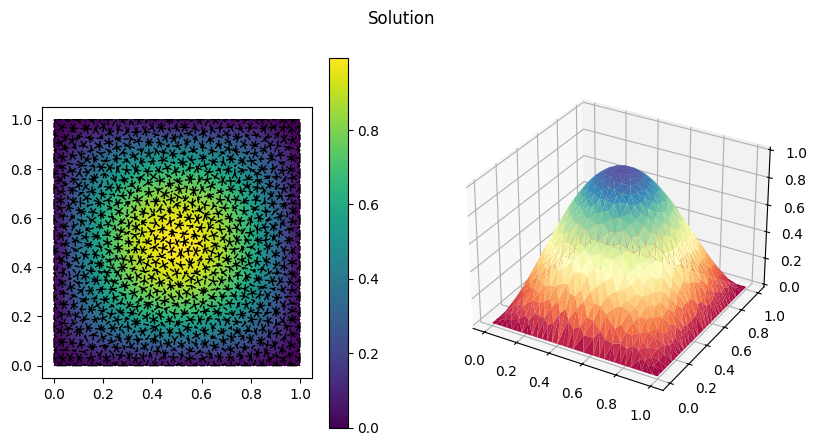

In [108]:
gedim.PlotSolution(mesh, dofs, strongs, predPoints, uStrong)

gedim.ExportSolution(exactSolution, predPoints, uStrong, lib)

## 3.2 PINN without exact solution
We now find an approximation of the unknown solution of our problem with forcing term
\begin{equation*}
    g(\mathbf{x};\mathbf{\mu})=100\,sin(2\pi x_0)\,cos(2\pi x_1)\quad \forall\,\mathbf{x}=(x_0, x_1) \in\Omega
\end{equation*}

### Offline phase - Training

In [29]:
size = 1000

# Boundaries' training set
x0Bc = np.random.uniform(low=0.0, high=1.0, size=(size, 1))
x1Bc = np.random.uniform(low=0.0, high=1.0, size=(size, 1))
allZeros = np.zeros((size, 1))
allOnes = np.ones((size, 1))
lX0 = np.concatenate([x0Bc, allOnes, x0Bc, allZeros], axis=0)
lX1 = np.concatenate([allZeros, x1Bc, allOnes, x1Bc], axis=0)

uBc = np.zeros((size * 4, 1))

# Parameters' training set
trainingSetMu0 = np.random.uniform(low=0.1, high=1.0, size=(size * 4, 1))
trainingSetMu1 = np.random.uniform(low=0.1, high=1.0, size=(size * 4, 1))

# Interior points' training set
x0Int = np.random.uniform(low=0.0, high=1.0, size=(size * 4, 1))
x1Int = np.random.uniform(low=0.0, high=1.0, size=(size * 4, 1))

In [32]:
from torch.optim.lr_scheduler import StepLR

def training(iterations, net, mse, optimizer, lX0, lX1, trainingSetMu0, trainingSetMu1, x0Int, x1Int, uBc):
    trainingLoss = []
    scheduler = StepLR(optimizer, step_size=500, gamma=0.5)
    for epoch in range(iterations):
        optimizer.zero_grad()

        # Loss based on boundary conditions
        ptX0Bc = Variable(torch.from_numpy(lX0).float(), requires_grad=False)
        ptX1Bc = Variable(torch.from_numpy(lX1).float(), requires_grad=False)
        mu0Tensor = Variable(torch.from_numpy(trainingSetMu0).float(), requires_grad=False)
        mu1Tensor = Variable(torch.from_numpy(trainingSetMu1).float(), requires_grad=False)
        # Homogeneous Dirichlet bc
        ptuBc = Variable(torch.from_numpy(uBc).float(), requires_grad=False)
        bcOutput = net(ptX0Bc, ptX1Bc, mu0Tensor, mu1Tensor) # output of u(x)
        mseU = mse(bcOutput, ptuBc)
        
        # Residual loss
        allZeros = np.zeros((size * 4, 1))
        ptX0Collocation = Variable(torch.from_numpy(x0Int).float(), requires_grad=True)
        ptX1Collocation = Variable(torch.from_numpy(x1Int).float(), requires_grad=True)
        ptAllZeros = Variable(torch.from_numpy(allZeros).float(), requires_grad=False) # We want a zero residual
        fOutput = R(ptX0Collocation, ptX1Collocation, mu0Tensor, mu1Tensor, net) # Residuals
        mseF = mse(fOutput, ptAllZeros)
        
        # Combining loss functions
        loss = mseF + coefficient * mseU
        loss.backward() 
        optimizer.step()
        scheduler.step()
        
        with torch.autograd.no_grad():
            if epoch % 1000 == 0:
                print(epoch,"Loss:",loss.item())
                print(f'{mseF}, {mseU}, {mseF / mseU}')
            if epoch % 10 == 0:
                trainingLoss.append(loss.item())
    return net, trainingLoss
        

In [ ]:
coeff = 5000
learningRate = 0.01
iterations = 15000
PATH = "model.pth"
net = Net()
mse = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learningRate)

[net, trainingLosses] = training(iterations, net, mse, optimizer, lx0, lx1, trainingSetMu0, trainingSetMu1, x0Int, x1Int, uBc)
torch.save(net.state_dict(), PATH)

# Evaluate pretrained model
net.load_state_dict(torch.load(PATH))

plt.clf()
plt.figure()
plt.plot(range(0, len(trainingLosses)), trainingLosses)
plt.title("Training Loss function")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig('training_loss.png')

### Online phase - Prediction

In [ ]:
# Interior points' test set
x0 = dofs[0].reshape(-1, 1)
x1 = dofs[1].reshape(-1, 1)
x0Tensor = Variable(torch.from_numpy(x0).float(), requires_grad=True) # To tensor
x1Tensor = Variable(torch.from_numpy(x1).float(), requires_grad=True)

mu = [0.8, 0.4]
mu0Tensor = torch.tensor(mu[0], dtype=torch.float32).expand(x0Tensor.size(0), 1)
mu1Tensor = torch.tensor(mu[1], dtype=torch.float32).expand(x1Tensor.size(0), 1)

[predPoints, mse] = predict(x0Tensor, x1Tensor, mu0Tensor, mu1Tensor, net, exact=False)
print(f'Test MSE: {mse}')

### Errors and SpeedUp of PINN vs FOM and POD

In [39]:
def errorPinnVsFom(predPoints, predPointsFom, uStrong):
    [numQuadPts, _, quadWgts, sol, solX, solY] = gedim.EvaluateSolutionOnPoints(predPoints, uStrong, lib)
    [_, _, _, solFom, solXFom, solYFom] = gedim.EvaluateSolutionOnPoints(predPointsFom, uStrong, lib)
    errorL2PINN = np.float64(0)
    errorH1PINN = np.float64(0)
    normL2Exact = 0
    normH1Exact = 0
    
    for q in range(numQuadPts):
        errorL2PINN = errorL2PINN + quadWgts[q] * np.square(solFom - sol[q])
        errorH1PINN = errorH1PINN + quadWgts[q] * (np.square(solXFom[0] - solX[q]) + np.square(solYFom[1] - solY[q]))
        
        normL2Exact = normL2Exact + quadWgts[q] * (np.square(solFom))
        normH1Exact = normH1Exact + quadWgts[q] * (np.square(solXFom[0]) + np.square(solYFom[1]))
    
    return np.sqrt(errorL2PINN), np.sqrt(errorH1PINN), np.sqrt(normL2Exact), np.sqrt(normH1Exact)

In [ ]:
absoluteErrorL2 = []
relativeErrorL2 = []
absolutEerrorH1 = []
relativeErrorH1 = []
testingSet = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(100, P.shape[0]))
mu0Tensor = torch.tensor(mu[0], dtype=torch.float32).expand(x0Tensor.size(0), 1)
mu1Tensor = torch.tensor(mu[1], dtype=torch.float32).expand(x1Tensor.size(0), 1)
uStrong = np.zeros(problemData['NumberStrongs'], order='F')
uKs = []

fomTime = time.time()
for mu in testingSet:
    uKs.append(fom(mu, lib, problemData, exactSol=False)[0]) # [0] means we only keep uK
fomTime = time.time() - fomTime

meanTimePINN = timePINN(x0Tensor, x1Tensor, mu0Tensor, mu1Tensor, net)

speedUpFomVsPINN = fomTime / meanTimePINN

predictedPoints = predict(x0Tensor, x1Tensor, mu0Tensor, mu1Tensor, net, exact=False)[0]
predictedPoints = predPoints.data.cpu().numpy().astype(np.float64)
predictedPoints = predPoints.reshape(-1)

for uK in uKs:
    [errorL2PinnVsFom, errorH1PinnVsFom, normL2Fom, normH1Fom] = errorPinnVsFom(predPoints, uK, uStrong)
    absoluteErrorL2.append(errorL2PinnVsFom)
    absolutEerrorH1.append(errorH1PinnVsFom)
    relativeErrorL2.append(errorL2PinnVsFom / normL2Fom)
    relativeErrorH1.append(errorH1PinnVsFom / normH1Fom)

pd.DataFrame({'Error_rel_L2_FOM_PINN': [np.mean(relativeErrorL2)], 'Error_abs_L2_FOM_PINN': [np.mean(absoluteErrorL2)], 'Error_rel_H1_FOM_PINN': [np.mean(relativeErrorH1)], 'Error_abs_H1_FOM_PINN': [np.mean(absolutEerrorH1)], 'Speed_up_FOM_PINN': [np.mean(speedUpFomVsPINN)]}).to_csv("speed_up_PINN_quadform.csv")

### Plot solution

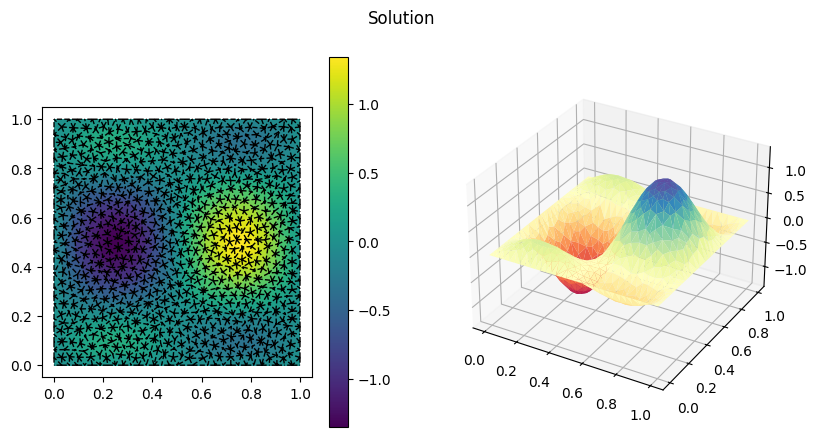

In [119]:
mu = [0.8, 0.4]
mu0Tensor = torch.tensor(mu[0], dtype=torch.float32).expand(x0Tensor.size(0), 1)
mu1Tensor = torch.tensor(mu[1], dtype=torch.float32).expand(x0Tensor.size(0), 1)

[predPoints, mse] = predict(x0Tensor, x1Tensor, mu0Tensor, mu1Tensor, net)

predPoints = predPoints.data.cpu().numpy().astype(np.float64)
predPoints = predPoints.reshape(-1)
uStrong = np.zeros(problemData['NumberStrongs'], order='F')

gedim.PlotSolution(mesh, dofs, strongs, predPoints, uStrong)

gedim.ExportSolution(exctSolution, predPoints, uStrong, lib)

# 4 POD-nn

## 4.1 POD-nn with exact solution
Firstly we solve the problem choosing the exact solution $u_{ex}(\mathbf{x}; \mathbf{\mu}) = 16\,x_0\,x_1\,(1 - x_0)(1 - x_1)$ and the respective right hand side
\begin{equation*}
    g_{ex}(\mathbf{x};\mathbf{\mu}) = 32x_0(1 - x_0) + 32x_1(1 - x_1) + \frac{\mu_0}{\mu_1} \left(e^{\mu_1\,16\,x_0\,x_1\,(1 - x_0)(1 - x_1)} - 1\right)
\end{equation*}

### Offline phase - build reduced space

In [85]:
snapshotsCount = 500
mu0Range = [0.1, 1.]
mu1Range = [0.1, 1.]
np.random.seed(1)

P = np.array([mu0Range, mu1Range])
trainingSet = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(snapshotsCount, P.shape[0]))

snapshotMatrix = buildSnapshotMatrix(problemData, trainingSet)
[N, innerProduct, eigenvectors] = covarianceMatrix(snapshotMatrix)
basis_functions = buildBasisFunctions(N, snapshotMatrix, innerProduct, eigenvectors)

### Offline phase - network

In [95]:
basisDimension = N # Reduced space's dim
inputDimension = P.shape # Parameter space's dim
outputDimension = basisDimension
nodes = 30 # number of nodes inside

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.nodes = nodes
        self.fc1 = nn.Linear(2, nodes) 
        self.fc2 = nn.Linear(nodes, nodes)
        self.fc3 = nn.Linear(nodes, nodes)
        self.fc4 = nn.Linear(nodes, nodes)
        self.fc5 = nn.Linear(nodes, 1)
        self.tanh = nn.Tanh() # activation function
    
    def forward(self, x):
        x = self.tanh(self.fc1(x))   
        x = self.tanh(self.fc2(x))
        x = self.tanh(self.fc3(x))
        x = self.tanh(self.fc4(x))
        x = self.fc5(x)
        return x
    
learningRate = 0.01
maxEpoches = 10000
epoch = 0
tolerance = 1e-5
loss = 1.

seed = 31
torch.manual_seed(seed)

net = Net()
mse = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learningRate)
torch.set_default_dtype(torch.float32)

### Offline phase - training

In [ ]:
reducedInnerProduct = np.transpose(basisFunctions) @ innerProduct @ basisFunctions
xTrain = torch.tensor(np.float32(trainingSet)) #the input is related to the training set that we have because the input are not the snapshots but the parameters
yTrain = []
# given the snapshots and the basis matrix B, the pi operator and the loss, the target is to solve the system
# X_N  u_{rb}(\mu) = (B^T X_\mathcal{N} B) u_{rb}(\mu) = B^T X_\mathcal{N} u^\mathcal{N}(\mu)
for i in range(snapshotMatrix.shape[0]):
    snapshot = snapshotMatrix[i]
    projectedSnapshot = np.linalg.solve(reducedInnerProduct, np.transpose(basisFunctions) @ innerProduct @ snapshot)
    yTrain.append(projectedSnapshot)
yTrain = np.float32(yTrain)
yTrain = torch.tensor(yTrain)

In [ ]:
from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=20, gamma=0.9)

while loss >= tolerance and epoch < maxEpoches:
    epoch = epoch + 1
    optimizer.zero_grad()
  
    output = net(xTrain)
    loss = mse(output, yTrain)
    loss.backward()
    # optimizer update
    optimizer.step() 
    scheduler.step()
    print("epoch", epoch, 'loss', loss.item(), 'lr', optimizer.param_groups[0]['lr'])

PATH = "exactModelPODNN.pth"
torch.save(net.state_dict(), PATH)

### Online phase

In [19]:
PATH = "model_exact_PODNN.pth"
learningRate = 0.01
net = Net()
mse = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learningRate)
net.load_state_dict(torch.load(PATH))

def predictPODNN(xTest, net): 
    xTest = np.float32(xTest)
    xTest = torch.tensor(xTest)
    reducedSolution = np.asarray(net(xTest).detach().numpy())[0] # Tensor to array
    uPrj = basisFunctions @ reducedSolution # Solution in the high fidelity setting
    return uPrj

# Compute solution
xTest = [[.8, .4]] # Different parameters from the ones chosen for the POD
uPrj = predictPODNN(xTest, net)

### H1 and L2 errors

In [ ]:
def exctSolution(quadPts):
    return 16.0 * (quadPts[1] * (1.0 - quadPts[1]) * quadPts[0] * (1.0 - quadPts[0]))

def exctDerSolution(quadPts):
    return [16.0 * (1.0 - 2.0 * quadPts[0]) * quadPts[1] * (1.0 - quadPts[1]), 16.0 * (1.0 - 2.0 * quadPts[1]) * quadPts[0] * (1.0 - quadPts[0])]

def errorExactVsPodnn(predPointsPodnn, uStrong):
    [numQuadPts, quadPts, quadWgts, sol, solX, solY] = gedim.EvaluateSolutionOnPoints(predPointsPodnn, uStrong, lib)
    errorL2 = np.float64(0)
    errorH1 = np.float64(0)
    normL2Exact = 0
    normH1Exact = 0
    
    for q in range(numQuadPts):
        excSol = exctSolution(quadPts[:, q])
        excSolDev = exctDerSolution(quadPts[:, q])
        
        errorL2 = errorL2 + quadWgts[q] * np.square(excSol - sol[q])
        errorH1 = errorH1 + quadWgts[q] * (np.square(excSolDev[0] - solX[q]) + np.square(excSolDev[1] - solY[q]))
        
        normL2Exact = normL2Exact + quadWgts[q] * (np.square(excSol))
        normH1Exact = normH1Exact + quadWgts[q] * (np.square(excSolDev[0]) + np.square(excSolDev[1]))
    
    return np.sqrt(errorL2), np.sqrt(errorH1), np.sqrt(normL2Exact), np.sqrt(normH1Exact)

#######################################################################################################################

order = 1
meshSize = 0.01
mu = [0.8, 0.4]
snapshotsCount = 300
mu0Range = [0.1, 1.]
mu1Range = [0.1, 1.]
uStrong = np.zeros(problemData['NumberStrongs'], order='F') 

# Build training set
np.random.seed(1)
P = np.array([mu0Range, mu1Range])
trainingSet = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(snapshotsCount, P.shape[0]))

# Build wroking mash
gedim.CreateDomainSquare({'SquareEdge': 1.0, 'VerticesBoundaryCondition': [1,1,1,1], 'EdgesBoundaryCondition': [1,1,1,1], 'DiscretizationType': 1, 'MeshCellsMaximumArea': meshSize}, lib)
problemData = gedim.Discretize({'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 2]} , lib)[0]

# Build reduced space
snapshotMatrix = buildSnapshotMatrix(problemData, trainingSet)
[N, innerProduct, eigenvectors] = covarianceMatrix(snapshotMatrix)
basis_functions = buildBasisFunctions(N, snapshotMatrix, innerProduct, eigenvectors)

# Build network
muDimension = P.shape
basisDimension = N
inputDimension = P.shape
outputDimension = basisDimension
nodes = 30

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.nodes = nodes
        self.fc1 = nn.Linear(2, nodes) 
        self.fc2 = nn.Linear(nodes, nodes)
        self.fc3 = nn.Linear(nodes, nodes)
        self.fc4 = nn.Linear(nodes, nodes)
        self.fc5 = nn.Linear(nodes, 1)
        self.tanh = nn.Tanh() # activation function
    
    def forward(self, x):
        x = self.tanh(self.fc1(x))   
        x = self.tanh(self.fc2(x))
        x = self.tanh(self.fc3(x))
        x = self.tanh(self.fc4(x))
        x = self.fc5(x)
        return x
    
learningRate = 0.01
maxEpoches = 10000
epoch = 0
tolerance = 1e-5
loss = 1.
seed = 31
torch.manual_seed(seed)
net = Net()
mse = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learningRate)
torch.set_default_dtype(torch.float32)

# Build reduced training set
reducedInnerProduct = np.transpose(basisFunctions) @ innerProduct @ basisFunctions
xTrain = torch.tensor(np.float32(trainingSet))
yTrain = []
for i in range(snapshotMatrix.shape[0]):
    snapshot = snapshotMatrix[i]  
    projectedSnapshot = np.linalg.solve(reducedInnerProduct, np.transpose(basisFunctions) @ innerProduct @ snapshot)
    yTrain.append(projectedSnapshot)
yTrain = np.float32(yTrain)
yTrain = torch.tensor(yTrain)

# Training
while loss >= tolerance and epoch < maxEpoches:
    epoch = epoch + 1
    optimizer.zero_grad()
    output = net(xTrain)
    loss = mse(output, yTrain)
    if epoch >= 20000:
        optimizer.param_groups[0]['lr'] = 0.0001  # reducing the learning rate if we go forward to the epoch. If we have a lr too large we don't follow the gradient direction but we could jump
    loss.backward()
    optimizer.step()
    print("epoch", epoch, 'loss', loss.item(), 'lr', optimizer.param_groups[0]['lr'])

# Prediction
xTest = [[.8, .4]]
uPrj = predictPODNN(xTest, net)

# Errors
[errorAbsoluteL2, errorAbsoluteH1, normL2, normH1] = errorExactVsPodnn(uPrj, uStrong)
errorRealtiveL2 = errorAbsoluteL2 / normL2
errorRealtiveH1 = errorAbsoluteH1 / normH1
print(errorRealtiveL2, errorRealtiveH1)

### Plot solution

In [ ]:
gedim.PlotSolution(mesh, dofs, strongs, uPrj, uStrong)

## 4.2 POD-nn without exact solution

### Offline phase - build reduced space

In [ ]:
seed = 31
learningRate = 0.01
torch.manual_seed(seed)
net = Net()
mse = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learningRate)
torch.set_default_dtype(torch.float32)
emaxEpoches = 10000
tolerance = 1e-5
epoch = 0
loss = 1.

#######################################################################################################################

mu = [0.8, 0.4]
snapshotsCount = 300
muoRange = [0.1, 1.]
mu1Range = [0.1, 1.]
P = np.array([mu0Range, mu1Range])
trainingSet = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(snapshotsCount, P.shape[0]))

snapshots = []
for mu in trainingSet:
    snapshots.append(np.copy(fom(mu, lib, problemData, exactSol=False)[0]))
snapshotMatrix = np.array(snapshots)

[N, innerProduct, eigenvectors] = covarianceMatrix(snapshotMatrix)
basisFunctions = buildBasisFunctions(N, snapshotMatrix, innerProduct, eigenvectors)

### Offline phase - network

In [27]:
nodes = 30

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.nodes = nodes
        self.fc1 = nn.Linear(2, nodes) 
        self.fc2 = nn.Linear(nodes, nodes)
        self.fc3 = nn.Linear(nodes, nodes)
        self.fc4 = nn.Linear(nodes, nodes)
        self.fc5 = nn.Linear(nodes, 3)
        self.Softplus = nn.Softplus()

    def forward(self, x):
        x = self.Softplus(self.fc1(x))   
        x = self.Softplus(self.fc2(x))
        x = self.Softplus(self.fc3(x))
        x = self.Softplus(self.fc4(x))
        x = self.fc5(x)
        return x

### Offline phase - training

<Figure size 640x480 with 0 Axes>

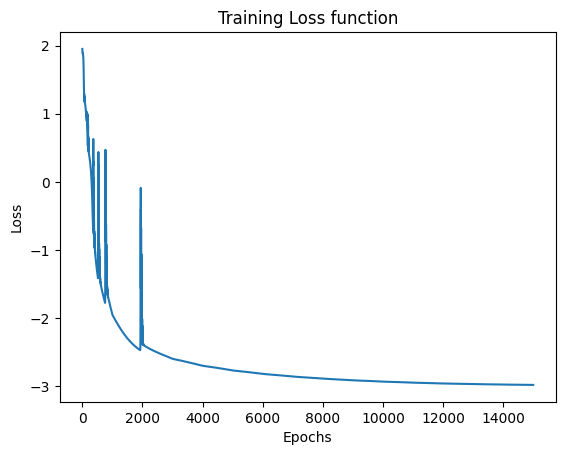

In [56]:
reducedInnerProduct = np.transpose(basisFunctions) @ innerProduct @ basisFunctions
xTrain = torch.tensor(np.float32(trainingSet))
yTrain = []
for i in range(snapshotMatrix.shape[0]):
    snapshot = snapshotMatrix[i]
    projectedSnapshot = np.linalg.solve(reducedInnerProduct, np.transpose(basis_functions) @ innerProduct @ snapshot)
    yTrain.append(projectedSnapshot)
yTrain = np.float32(yTrain)
yTrain = torch.tensor(yTrain)

from torch.optim.lr_scheduler import StepLR

seed = 42
learningRate = 0.01
torch.manual_seed(seed)
net = Net()
mse = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learningRate)
torch.set_default_dtype(torch.float32)
maxEpoches = 15000
epoch = 0
tol = 1e-5
loss = 1.
scheduler = StepLR(optimizer, step_size=1000, gamma=0.5)
trainingLoss = []

while loss >= tol and epoch < maxEpoches:
    epoch = epoch + 1
    optimizer.zero_grad()
    output = net(xTrain)
    loss = mse(output, yTrain)
    #if epoch >= 500:
    #   optimizer.param_groups[0]['lr'] = 0.001  # reducing the learning rate if we go forward to the epoch. If we have a lr too large we don't follow the gradient direction but we could jump
    #if epoch >= 4000:
    #   optimizer.param_groups[0]['lr'] = 0.0001
    loss.backward()
    optimizer.step()
    scheduler.step()
    trainingLoss.append(loss.item())
    print("epoch", epoch, 'loss', loss.item(), 'lr', optimizer.param_groups[0]['lr'] )

PATH = "model_PODNN.pth"
torch.save(net.state_dict(), PATH)

plt.clf()
plt.figure()
plt.plot(range(0, len(trainingLoss)), np.log10(trainingLoss))
plt.title("Training Loss function")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig('training_loss.png')

learningRate = 0.01
net = Net()
mse = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learningRate)
net.load_state_dict(torch.load(PATH))

# Compute the solution
xTest = [[.8, .4]]
uPrj = predictPODNN(xTest, net)

### POD-nn errors and speedUp

In [61]:
def timePodnn(testingSet, net):
    startTime = time.time()
    for mu in testingSet:
        predictPODNN(mu, net)
    meanTime = (time.time() - startTime) / len(testingSet)
    print(f'Mean PODNN prediction time: ', meanTime)
    return meanTime

def errorPodnnVsFom(uPrj, u, uStrong):
    [numQuadraturePoints, _, quadratureWeights, sol, solX, solY] = gedim.EvaluateSolutionOnPoints(uPrj, uStrong, lib)
    [_, _, _, solFom, solXFom, solYFom] = gedim.EvaluateSolutionOnPoints(u, uStrong, lib)
    errorL2Podnn = np.float64(0)
    errorH1Podnn = np.float64(0)
    normL2 = 0
    normH1 = 0
    for q in range(numQuadraturePoints):
        errorL2Podnn = errorL2Podnn + quadratureWeights[q] * np.square(solFom[q] - sol[q])
        errorH1Podnn = errorH1Podnn + quadratureWeights[q] * (np.square(solXFom[q] - solX[q]) + np.square(solYFom[q] - solY[q]))
        normL2 = normL2 + quadratureWeights[q] * (np.square(solFom[q]))
        normH1 = normH1 + quadratureWeights[q] * (np.square(solXFom[q]) + np.square(solYFom[q]))
    return np.sqrt(errorL2Podnn), np.sqrt(errorH1Podnn), np.sqrt(normL2), np.sqrt(normH1)

absoluteErrorL2 = []
absoluteErrorH1 = []
relativeErrorL2 = []
relativeErrorH1 = []
testingSet = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(100, P.shape[0]))
uStrong = np.zeros(problemData['NumberStrongs'], order='F')
uS = []

fomTime = time.time()
for mu in testingSet:
    uS.append(fom(mu, lib, problemData, exactSol=False)[0])
fomTime = time.time() - fomTime

meanTimePodnn = timePodnn(testingSet, net)
speedUpPodnn = fomTime / (meanTimePodnn * len(testingSet))

for i in range(len(testingSet)):
    xTest = [testingSet[i]]
    uPrj = predictPODNN(xTest, net)
    [errorL2Podnn, errorH1Podnn, normL2, normH1] = errorPodnnVsFom(uPrj, uS[i], uStrong)
    absoluteErrorL2.append(errorL2Podnn)
    absoluteErrorH1.append(errorH1Podnn)
    relativeErrorL2.append(errorL2Podnn / normL2)
    relativeErrorH1.append(errorH1Podnn / normH1)
print("Average Relative L2 error: ", np.mean(relativeErrorL2))
print("Average Absolute L2 error: ", np.mean(absoluteErrorL2))
print("Average Relative H1 error: ", np.mean(relativeErrorH1))
print("Average Absolute H1 error: ", np.mean(absoluteErrorH1))
print("SpeedUp: ", speedUp)

pd.DataFrame({'Error_rel_L2_FOM_ROM': [np.mean(relativeErrorL2)], 'Error_abs_L2_FOM_ROM': [np.mean(absoluteErrorL2)], 'Error_rel_H1_FOM_ROM': [np.mean(relativeErrorH1)], 'Error_abs_H1_FOM_ROM': [np.mean(absoluteErrorH1)], 'Speed_up_POD': [speedUp]}).to_csv("speed_up_PODNN_quadform.csv")

average relative error in L2 =  0.003173490422279252
average absolute error in L2 =  0.0016408364415941307
average relative error in H1 =  0.0031809211974109476
average absolute error in H1 =  0.014589086010417798
average speed_up wrt FOM =  2930.135040737831


### Plot solution

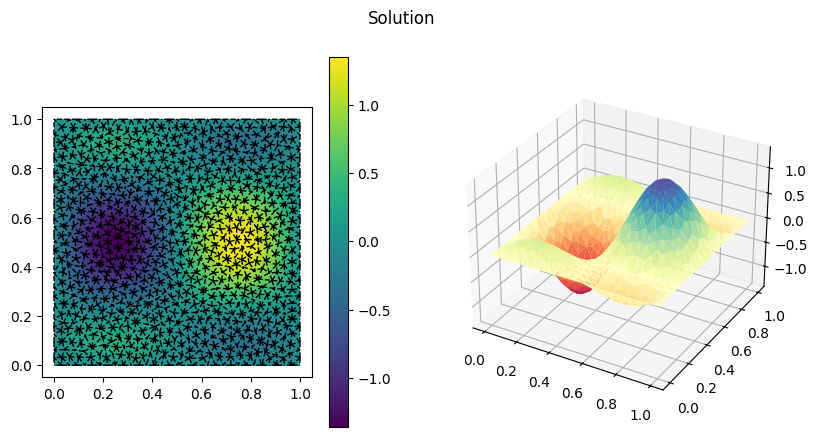

In [62]:
uPrj = predictPODNN([0.8, 0.4], net)
gedim.PlotSolution(mesh, dofs, strongs, uPrj, uStrong)

gedim.ExportSolution(exctSolution, uPrj, uStrong, lib)